We need to compare k-means, hdbscan, quickshift, and classix

## Face clustering

In [1]:
import hdbscan
from sklearn.cluster import KMeans
from quickshift.QuickshiftPP import *
from threadpoolctl import threadpool_limits

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from classix import CLASSIX, loadData
import classix
from time import time
import cv2
import os


import pandas as pd
import numpy as np

print(classix.__version__)

from HiPart.clustering import DePDDP
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami

import collections


1.0.5


In [3]:
def order_pics(figs):
    images = list()
    labels = list()
    for i in range(40):
        num = i + 1
        for img in figs:
            try:
                if int(img.split('_')[1].replace('.jpg','')) == num:
                    images.append(img)
                    labels.append(num)
            except:
                pass
    return images, labels
    
def load_images(folder, shape=(100, 100)):
    images = list()
    figs = os.listdir(folder)
    figs, targets= order_pics(figs)
    for filename in figs:
        img = cv2.imread(os.path.join(folder,filename)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        img = cv2.resize(img, shape, interpolation = cv2.INTER_AREA) # resize to 80x80
        if img is not None:
            images.append(img)
    images, targets = np.array(images), np.array(targets) - 1
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    return images, targets

lari = list()
lami = list()
runtime = list()

folder = 'OlivettiFaces'
X, y = load_images(folder)
clusterNum = len(np.unique(y))

min_cluster = min(collections.Counter(y).items(), key=lambda x: x[1])[1]

with threadpool_limits(limits=1, user_api='blas'):
    clx = CLASSIX(sorting='pca', radius=0.54, minPts=3, verbose=0, group_merging='distance')
    st = time()
    clx.fit(X)
    et = time()
    print("CLASSIX uses time:", et - st)
    print("ARI:", ari(clx.labels_, y))
    print("AMI:", ami(clx.labels_, y))
    lari.append(ari(clx.labels_, y))
    lami.append(ami(clx.labels_, y))
    runtime.append(et - st)

    _hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, algorithm='best')
    st = time()
    _hdbscan.fit(X)
    et = time()
    print("HDBSCAN uses time:", et - st)
    print("ARI:", ari(_hdbscan.labels_, y))
    print("AMI:", ami(_hdbscan.labels_, y))
    lari.append(ari(_hdbscan.labels_, y))
    lami.append(ami(_hdbscan.labels_, y))
    runtime.append(et - st)

    quicks = QuickshiftPP(k=9, beta=0.7)
    st = time()
    quicks.fit(X.copy(order='C'))
    et = time()
    print("Quickshift uses time:", et - st)
    print("ARI:", ari(quicks.memberships, y))
    print("AMI:", ami(quicks.memberships, y))
    lari.append(ari(quicks.memberships, y))
    lami.append(ami(quicks.memberships, y))
    runtime.append(et - st)

    kmeans = KMeans(n_clusters=clusterNum, init='k-means++', random_state=1)
    st = time()
    kmeans.fit(X)
    et = time()
    print("kmeans uses time:", et - st)
    print("ARI:", ari(kmeans.labels_, y))
    print("AMI:", ami(kmeans.labels_, y))
    lari.append(ari(kmeans.labels_, y))
    lami.append(ami(kmeans.labels_, y))
    runtime.append(et - st)

    # depddp_class = DePDDP(max_clusters_number=clusterNum).fit_predict(X)
    # print("DePDDP uses time:", et - st)
    # print("ARI:", ari(depddp_class, y))
    # print("AMI:", ami(depddp_class, y))
    # lari.append(ari(depddp_class, y))
    # lami.append(ami(depddp_class, y))
    # runtime.append(et - st)

labels_ = [clx.labels_, _hdbscan.labels_, quicks.memberships, kmeans.labels_]# , depddp_class]
lari = np.asarray(lari)
lami = np.asarray(lami)
runtime = np.asarray(runtime)
np.save("result/exp1/olivetti_ari.npy", lari)
np.save("result/exp1/olivetti_ami.npy", lami)
np.save("result/exp1/olivetti_runtime.npy", runtime)
np.save("result/exp1/olivetti_labels.npy", labels_)

CLASSIX uses time: 1.13997220993042
ARI: 0.6655494516761021
AMI: 0.839551568838854
HDBSCAN uses time: 3.9601776599884033
ARI: 0.3940236570910377
AMI: 0.7273864449199154
Quickshift uses time: 3.698025703430176
ARI: 0.6588833850300853
AMI: 0.8399985246684827


/usr/lib/python3/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans uses time: 5.143144369125366
ARI: 0.6370368301567606
AMI: 0.7810840623704158


/tmp/ipykernel_1679317/777750845.py:119: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)


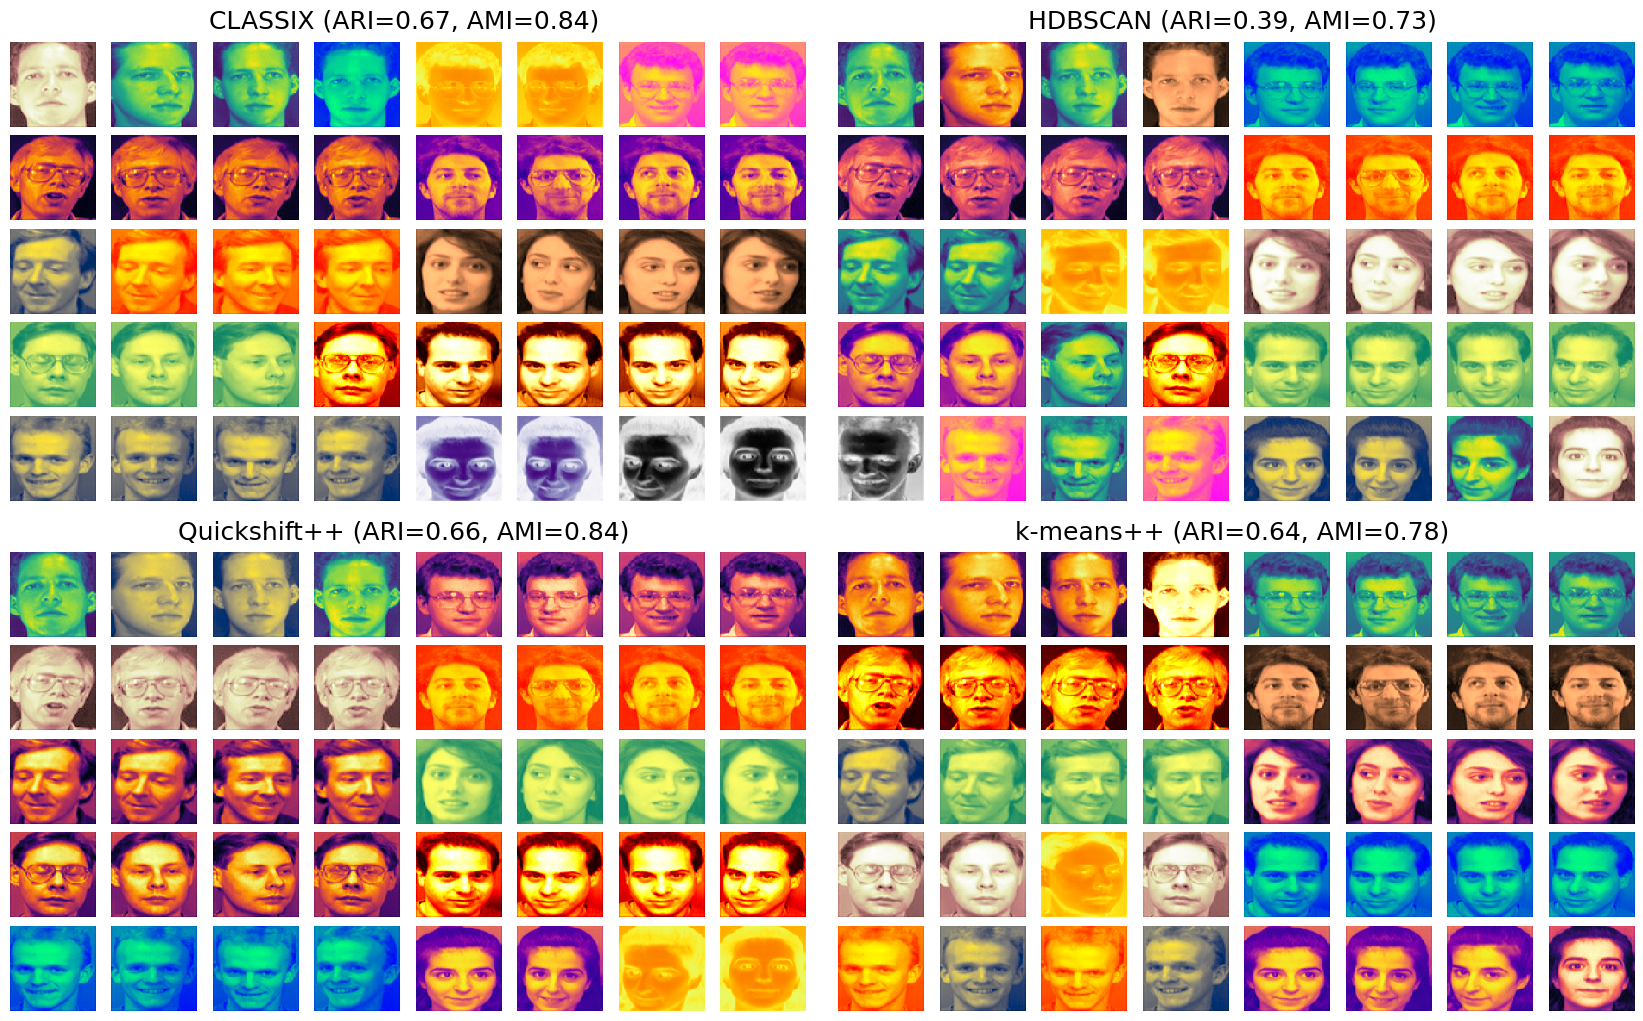

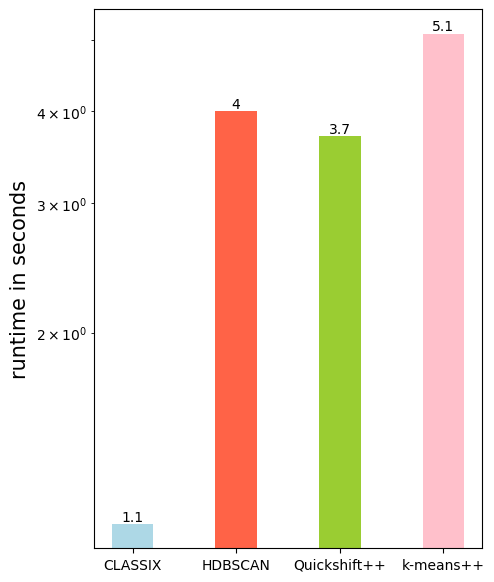

In [4]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import math

def sigificant_digit(number, digits=4):
    return round(number, digits - int(math.floor(math.log10(abs(number)))) - 1)

def order_pics(figs):
    images = list()
    labels = list()
    for i in range(40):
        num = i + 1
        for img in figs:
            try:
                if int(img.split('_')[1].replace('.jpg','')) == num:
                    images.append(img)
                    labels.append(num)
            except:
                pass
    return images, labels
    
def load_images(folder, shape=(100, 100)):
    images = list()
    figs = os.listdir(folder)
    figs, targets= order_pics(figs)
    for filename in figs:
        img = cv2.imread(os.path.join(folder,filename)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        img = cv2.resize(img, shape, interpolation = cv2.INTER_AREA) # resize to 80x80
        if img is not None:
            images.append(img)
    images, targets = np.array(images), np.array(targets) - 1
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    return images, targets

folder = 'OlivettiFaces'
X, y = load_images(folder)
clear_cmaps =  [ 'viridis', 'cividis', 'pink', 'inferno', 'winter', 
                'copper','magma', 'autumn', 'summer', 'hot', 'plasma', 'Wistia',  
                'afmhot','spring']

cmaps = OrderedDict()

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Sequential_2'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']


algorithms = ['CLASSIX', 'HDBSCAN', 'Quickshift++', 'k-means++']
lari = np.load("result/exp1/olivetti_ari.npy")
lami = np.load("result/exp1/olivetti_ami.npy")
labels = np.load("result/exp1/olivetti_labels.npy")
runtime = np.load("result/exp1/olivetti_runtime.npy")
runtime = [sigificant_digit(c, 2) for c in runtime]

cmaps_ = clear_cmaps + cmaps['Sequential'] + cmaps['Diverging'] + cmaps['Miscellaneous'] 


fig = plt.figure(constrained_layout=True, figsize=(8.2*2, 5.05*2))
subfigs = fig.subfigures(2, 2)
ii = 0


for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(algorithms[ii] + ' (ARI={0:.2f}, AMI={1:.2f}) '.format(lari[ii], lami[ii]), fontsize=18)
    axs = subfig.subplots(5, 8)
    
    labels_ = list()
    for i in range(5):
        for j in range(5):
            labels_.append(labels[ii][i*10 + j])
    for i in np.arange(5, 10):
        for j in range(5):
            labels_.append(labels[ii][i*10 + j])

    unique = np.unique(labels_)
    labels_change = np.arange(len(unique))
    labels_change = dict(zip(unique, labels_change))

    image_shape = (100, 100)

    for i in range(5):
        for j in range(4):
            axs[i,j].axis("off")
            axs[i,j].imshow(X[i*10 + j].reshape(image_shape),
                   cmap=cmaps_[labels_change[labels[ii][i*10 + j]]],
                   interpolation="nearest")

            axs[i,j+4].axis("off")
            axs[i,j+4].imshow(X[(i+5)*10 + j].reshape(image_shape),
                   cmap=cmaps_[labels_change[labels[ii][(i+5)*10 + j]]],
                   interpolation="nearest")
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
    ii = ii + 1

plt.savefig('result/exp1/scatter_olivetti.png', bbox_inches='tight')
plt.show()


color = ['lightblue', 'tomato', 'yellowgreen', 'pink']
plt.figure(figsize=(5, 7))
plt.bar(algorithms, runtime, width=0.4, color=color)
plt.yscale('log')
plt.ylabel('runtime in seconds', fontsize=15)
for c in plt.gca().containers:
    plt.gca().bar_label(c)
    
plt.savefig('result/exp1/bar_olivetti.png', bbox_inches='tight')
plt.show()